In [4]:
!pip install torchinfo torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 12.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!ls

sample_data
sample_data


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import random
from torchmetrics import CharErrorRate
import pandas as pd

In [6]:
from torchinfo import summary

In [7]:
BATCH_SIZE = 64
DEVICE = 'cuda'
ALPHABET_SIZE = 10 + 26
WHITE_FILL = 255

In [8]:
import numpy as np
from glob import glob
from matplotlib.pyplot import imread
from PIL import Image
from sklearn.model_selection import train_test_split

import time
import os
import matplotlib.pyplot as plt


torch.Size([1, 1, 50, 200])


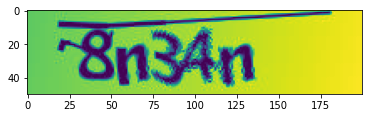

In [11]:
def label2arr(label):
  return [int(x) if x.isnumeric() else 10 + ord(x) - ord('a') for x in label]

def arr2label(arr):
  return [str(x) if x < 10 else chr(x - 10 + ord('a')) for x in arr]


def label2ohe(label):
  arr = [int(x) if x.isnumeric() else 10 + ord(x) - ord('a') for x in label]
  return  F.one_hot(
      torch.LongTensor( arr), num_classes=36
    )
  


def load_captchas(
    path=r'sample_data//',
):
    show = True
    data, labels = [], []
    for img_path in glob(os.path.join(path,'*.png')):
        class_i = img_path.split(os.sep)[-1].split('.')[-2]
        img = Image.open(img_path).convert("L")
        img_data = img.getdata()
        #arr = np.array(img_data, dtype=np.float32)[:, 0].reshape(img.size[0], img.size[1])
        arr = np.array(img_data, dtype=np.float32).reshape(img.size[1], img.size[0])
        
        data.append(torch.unsqueeze((transforms.ToTensor()(arr)), -1).permute(0, 3, 1, 2))
        labels.append(torch.unsqueeze(torch.LongTensor(label2arr(class_i)), 0))
        #labels.append(torch.unsqueeze(label2ohe(class_i).float(), 0))
        if show:
          print(data[-1].shape)
          show = False
          #plt.imshow(img)
          plt.imshow(arr)
          plt.show()
    
    arr = list(zip(data, labels))
    random.shuffle(arr)
    data, labels = zip(*arr)

    return data, labels


data, labels = load_captchas()

In [ ]:
img = data[0]
print(img.shape)
#img = transforms.RandomRotation(degrees=(0, 2), fill=255)(img)
#img1 = transforms.functional.rotate(img, 5, fill=255)
img1 = transforms.RandomPerspective(distortion_scale=0.3, fill=WHITE_FILL)(img)
print(img.shape)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.squeeze().numpy())
ax[1].imshow(img1.squeeze().numpy())
plt.show()

In [12]:
class DatasetCaptcha(Dataset):
    def __init__(self, data, labels, transform=None, test=False, test_size=0.2):
        train_len = int(len(data) * (1 - test_size))
        if test:
          data = data[train_len:]
          labels = labels[train_len:]
        else:
          data = data[:train_len]
          labels = labels[:train_len]
        self.data = torch.cat(data)
        self.labels = torch.cat(labels)
        #print(self.data.shape)
        self.transform = transform

    def __len__(self):
        #print(self.data.shape, self.labels.shape)
        return len(self.data)

    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        
        image = self.data[index]
        label = self.labels[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label


Без использования transforms модель не учится, а сразу переучивается. Поэтому приходится применять к изображениям какие-то искажения. 

load_captchas перемешала датасет, поэтому разделяем на трейн и тест как первые 4 части - трейн, последние - тест.

In [13]:
from torchvision.transforms.transforms import RandomPerspective
#data, labels = load_captchas(path='drive/MyDrive/samples/')

img_transforms = transforms.RandomApply(nn.ModuleList([
    transforms.RandomAffine(degrees=(-2, 2), fill=WHITE_FILL), 
    transforms.RandomRotation(degrees=(-5, 5), fill=WHITE_FILL), 
    transforms.RandomAdjustSharpness(1.5),
    transforms.RandomPerspective(distortion_scale=0.2, fill=WHITE_FILL), 
]))
training_data = DatasetCaptcha(data, labels, transform=img_transforms, test=False, test_size=0.2)
valid_data = DatasetCaptcha(data, labels, test=True, test_size=0.2)

train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=64, shuffle=True)
print(valid_data[0])
print(len(valid_data))

print(len(training_data))

(tensor([[[192., 192., 192.,  ..., 251., 251., 251.],
         [192., 192., 192.,  ..., 251., 251., 251.],
         [192., 192., 192.,  ..., 251., 251., 251.],
         ...,
         [195., 195., 195.,  ..., 254., 254., 254.],
         [195., 195., 195.,  ..., 254., 254., 254.],
         [195., 195., 195.,  ..., 254., 254., 254.]]]), tensor([34, 13, 16,  8, 23]))
208
832


Вот эта модель почему-то не учится. Не удалось подобрать гиперпараметры, чтобы училась. Она значительно меньше, чем та, что в итоге заработала, около 200K параметров, видимо, задача сложнее

In [ ]:
class Model1(nn.Module): # https://medium.com/swlh/captcha-recognition-44522c2fe9c
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 32, (3, 3)),
        nn.ReLU(),
        nn.Conv2d(32, 32, (3, 3)),
        nn.ReLU(),
        nn.MaxPool2d((1, 2), stride=2),
        nn.Conv2d(32, 64, (3, 3)),
        nn.ReLU(),
        nn.Conv2d(64, 64, (3, 3)),
        nn.ReLU(),
        nn.MaxPool2d((1, 2), stride=2),
        nn.Conv2d(64, 64, (3, 3)),
        nn.ReLU(),
        nn.Conv2d(64, 64, (3, 3)),
        nn.ReLU(),
        nn.MaxPool2d((1, 2), stride=2),
        nn.Conv2d(64, 36, (1, 1)),
        nn.ReLU(),
    )

    self.lin = nn.Sequential(
        nn.Linear(63, 5)
    )
    

  def forward(self, input):
    input = self.conv(input)

    #input = input.permute(0, 3, 1, 2)
    input = input.view(input.size(0), input.size(1), -1)

    input = self.lin(input)

    #return input.permute(0, 2, 1)
    return input

Вот эта учится, построена на основе статьи из которой иллюстрация

In [14]:
class Model(nn.Module): #https://www.researchgate.net/publication/348941378_A_limited-size_ensemble_of_homogeneous_CNNLSTMs_for_high-performance_word_classification
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(1, 64, (3, 3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Dropout(0.5),
        nn.MaxPool2d((2, 2), stride=2),
        nn.Conv2d(64, 128, (3, 3), padding=1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.MaxPool2d((2, 2), stride=2),
        nn.Conv2d(128, 256, (3, 3), padding=1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.MaxPool2d((1, 2), stride=2),
        nn.Conv2d(256, 512, (3, 3), padding=1),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.BatchNorm2d(512),
        nn.MaxPool2d((1, 2), stride=2),
        nn.Conv2d(512, 512, (2, 2)),
        nn.MaxPool2d((1, 2), stride=2),
        nn.Dropout(0.5),
    )

    self.rnn = nn.Sequential(
        nn.Linear(512, 256),
        nn.LSTM(256, 256, bidirectional=True, batch_first=True, num_layers=2), 
        
    )

    self.lin = nn.Linear(512, 26+10)

  def forward(self, input):
    input = self.conv(input)
    #print(input.shape)
        
    input = input.permute(0, 3, 1, 2)
    input = input.view(input.size(0), input.size(1), -1)

    input = self.rnn(input)[0]

    return self.lin(input).permute(0, 2, 1)

In [84]:
model = Model()
summary(model, input_size=(32, 1, 50, 200))


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [32, 36, 5]               --
├─Sequential: 1-1                        [32, 512, 1, 5]           --
│    └─Conv2d: 2-1                       [32, 64, 50, 200]         640
│    └─ReLU: 2-2                         [32, 64, 50, 200]         --
│    └─BatchNorm2d: 2-3                  [32, 64, 50, 200]         128
│    └─Dropout: 2-4                      [32, 64, 50, 200]         --
│    └─MaxPool2d: 2-5                    [32, 64, 25, 100]         --
│    └─Conv2d: 2-6                       [32, 128, 25, 100]        73,856
│    └─ReLU: 2-7                         [32, 128, 25, 100]        --
│    └─Dropout: 2-8                      [32, 128, 25, 100]        --
│    └─MaxPool2d: 2-9                    [32, 128, 12, 50]         --
│    └─Conv2d: 2-10                      [32, 256, 12, 50]         295,168
│    └─ReLU: 2-11                        [32, 256, 12, 50]         --
│   

In [16]:
show = True

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_cer = []
    errors = pd.DataFrame()
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_cer = []
        start_time = time.time()


        model.train(True) 
        for X_batch, y_batch in train_loader:
            global show
            if show:
              show = False
              plt.imshow(X_batch[0].squeeze().numpy())
              plt.show()
            opt.zero_grad()
            y_pred = model(X_batch.to(DEVICE))

            #y_pred_ = pd.DataFrame(y_pred.argmax(dim=1).detach().cpu().numpy()).apply(arr2label, axis=1)
            #y_batch_ = pd.DataFrame(y_batch.cpu().numpy()).apply(arr2label, axis=1)
            #print(y_pred_[0], y_batch_[0])
            # print(y_pred.shape, y_batch.shape)
            # print(y_pred, y_batch)
            # input()
            loss = loss_fn(y_pred.to(DEVICE), 
                           y_batch.to(DEVICE))
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.)
            opt.step()
            ep_train_loss.append(loss.item())

        model.train(False) 
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch.to(DEVICE))
                y_pred_label = pd.DataFrame(y_pred.argmax(dim=1).detach().cpu().numpy()).apply(arr2label, axis=1)
                y_batch_label = pd.DataFrame(y_batch.cpu().numpy()).apply(arr2label, axis=1)
                mask = y_pred_label == y_batch_label
                errors = pd.concat((errors, pd.concat((y_pred_label[~mask], y_batch_label[~mask]), axis=1)),
                                    axis=0    
                                   )
                #print(y_pred_[0], y_batch_[0])
                ep_val_cer.append(CharErrorRate()(
                    y_pred_label, 
                    y_batch_label
                    ))
                
                loss = loss_fn(y_pred.to(DEVICE), 
                               y_batch.to(DEVICE))

                ep_val_loss.append(loss.item())

                

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_cer.append(np.mean(ep_val_cer))
        
        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation cer: {val_cer[-1]:.3f}")

    return train_loss, val_loss, val_cer,errors

Из всех комбинаций optimizer, lr, batch_size лучше всего заработало:

In [24]:
model = Model().to(DEVICE)
loss = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
train_loss, val_loss, val_cer, errors = train_model(model, train_loader, val_loader, loss_fn=loss, opt=optim, n_epochs=250)

Epoch 1 of 250 took 1.813s
	  training loss: 3.123972
	validation loss: 2.960335
	validation cer: 0.907
Epoch 2 of 250 took 1.888s
	  training loss: 2.945140
	validation loss: 2.922855
	validation cer: 0.907
Epoch 3 of 250 took 1.825s
	  training loss: 2.900531
	validation loss: 2.761781
	validation cer: 0.873
Epoch 4 of 250 took 1.679s
	  training loss: 2.784752
	validation loss: 2.616946
	validation cer: 0.828
Epoch 5 of 250 took 1.768s
	  training loss: 2.686484
	validation loss: 2.508327
	validation cer: 0.855
Epoch 6 of 250 took 1.722s
	  training loss: 2.598074
	validation loss: 2.344993
	validation cer: 0.832
Epoch 7 of 250 took 1.728s
	  training loss: 2.541572
	validation loss: 2.314867
	validation cer: 0.849
Epoch 8 of 250 took 1.707s
	  training loss: 2.493590
	validation loss: 2.422685
	validation cer: 0.855
Epoch 9 of 250 took 1.945s
	  training loss: 2.459329
	validation loss: 2.178736
	validation cer: 0.794
Epoch 10 of 250 took 1.911s
	  training loss: 2.380539
	validati

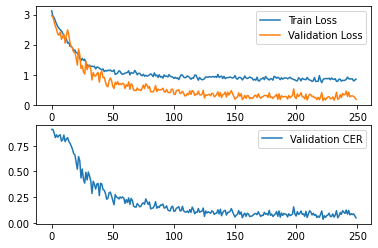

In [25]:
fig, axes = plt.subplots(2)
axes[0].plot(train_loss, label="Train Loss")
axes[0].plot(val_loss, label="Validation Loss")
#axes[0].title("Loss stats")
axes[0].legend()

axes[1].plot(val_cer, label="Validation CER")
axes[1].legend()
plt.show()

# Анализ ошибок

In [91]:
li = list(map(lambda x, y: x + y, errors.iloc[:, 0].to_list(), errors.iloc[:, 1].to_list()))
df_errors = pd.DataFrame.from_records(li, columns=[f'pred_{i+1}' for i in range(5)] + [f'true_{i+1}' for i in range(5)])

Во время обучения ошибки на тестовой части записывались в dataframe. Начало датафрейма неинформативное, там модель выдает случайные предсказания, и много ошибается. 
Ближе к концу те ошибки, которые не удалось выучить. (Стоило в датафрейм еще записывать номер эпохи, но лимит использования гпу уже кончился, а на цпу оно учится часами, так что пока так).
В качестве первого приближения просто отбросим начало датафрейма.

In [92]:
df_errors = df_errors.iloc[25000:, :]
mask = [df_errors[f'pred_{i+1}'] != df_errors[f'true_{i+1}'] for i in range(5)]

В df_errors в каждой строке 10 символов, первые пять - предсказанные, дальше - истинные. Отдельно рассмотрим ошибки на каждой позиции.

In [110]:
df_errors

,pred_1,pred_2,pred_3,pred_4,pred_5,true_1,true_2,true_3,true_4,true_5
25000,x,b,n,m,6,x,b,e,m,6
25001,f,f,p,8,f,f,f,p,x,f
25002,n,w,m,c,n,n,w,n,c,n
25003,p,p,7,c,5,g,p,7,c,5
25004,f,c,6,4,b,f,c,6,x,b
...,...,...,...,...,...,...,...,...,...,...
28172,p,g,3,n,m,p,g,2,p,m
28173,m,3,m,6,x,n,3,m,6,x
28174,w,f,3,4,7,y,f,3,4,7
28175,x,c,w,4,4,x,x,w,4,4


In [93]:
from collections import Counter
errors_pos = [df_errors[mask[i]].loc[:, [f'pred_{i+1}', f'true_{i+1}']].groupby(by=f'true_{i+1}')[f'pred_{i+1}'].apply(list) for i in range(5)]

В первом символе чаще всего модель видит w вместо y, m вместо w.

In [94]:

errors_pos[0].apply(Counter)

true_1
2                                            {'7': 12}
5                     {'7': 9, 'f': 2, '8': 1, '6': 1}
6                                             {'b': 4}
7                                     {'5': 5, '3': 1}
8                                             {'3': 2}
c            {'e': 75, 'p': 4, '8': 8, 'x': 5, 'g': 2}
d                                             {'g': 1}
e           {'4': 7, 'p': 12, '6': 6, 'w': 8, '8': 13}
g          {'p': 29, 'n': 78, 'm': 11, 'e': 2, 'd': 1}
m                                            {'n': 35}
n                            {'b': 1, 'm': 55, 'p': 4}
p                                    {'n': 45, 'b': 5}
w                                           {'m': 222}
x    {'3': 11, 'e': 11, 'w': 9, 'y': 10, '2': 2, '8...
y          {'w': 300, 'm': 17, 'g': 2, 'p': 3, 'n': 1}
Name: pred_1, dtype: object

Во втором символе чаще всего модель видит n вместо p.

In [95]:
errors_pos[1].apply(Counter)

true_2
2                                    {'3': 59, '7': 5}
3                                     {'8': 2, '4': 2}
4                                             {'d': 2}
c           {'d': 20, 'e': 7, 'x': 4, 'f': 2, 'g': 11}
d    {'g': 7, 'n': 8, 'b': 30, '4': 1, 'm': 2, 'f': 3}
e    {'g': 29, 'p': 7, '4': 7, 'w': 17, 'm': 1, 'n'...
f                                             {'6': 4}
m                                            {'n': 71}
n                            {'b': 5, 'm': 38, 'p': 4}
p                           {'n': 232, 'm': 3, 'g': 1}
w                                   {'m': 57, 'n': 14}
x           {'y': 22, '4': 2, '8': 8, 'c': 13, 'e': 1}
y                             {'w': 5, 'm': 2, 'n': 1}
Name: pred_2, dtype: object

В третьем символе опять n вместо p, еще заметно, что m вместо n.

In [96]:
errors_pos[2].apply(Counter)

true_3
2                                    {'3': 63, '7': 4}
3                                     {'8': 5, '4': 2}
5                                             {'6': 9}
6            {'n': 42, '8': 6, 'b': 1, 'p': 1, '5': 1}
7                             {'2': 4, '5': 2, 'f': 1}
c            {'d': 23, 'p': 2, '4': 1, 'e': 3, 'g': 2}
e    {'n': 32, 'p': 13, 'm': 9, 'w': 5, 'g': 28, '4...
g                            {'p': 8, 'n': 10, 'd': 1}
m                                            {'n': 75}
n                                    {'m': 93, 'b': 3}
p                           {'n': 144, 'b': 9, '6': 3}
w           {'d': 1, 'm': 26, 'n': 21, '4': 7, 'g': 1}
x           {'p': 57, 'e': 12, 'y': 9, 'w': 1, 'n': 2}
y                    {'w': 45, '2': 1, 'm': 4, 'x': 1}
Name: pred_3, dtype: object

В четвертом символе опять n вместо p, и снова w вместо y.

In [97]:
errors_pos[3].apply(Counter)

true_4
2                                             {'3': 8}
3                                     {'8': 5, '4': 1}
4                                             {'d': 4}
5                   {'6': 13, 'f': 2, '8': 24, '7': 2}
6                                             {'5': 2}
7                             {'5': 4, '3': 3, 'f': 3}
8                                             {'3': 1}
b                                             {'6': 1}
c                             {'d': 2, 'p': 6, 'g': 3}
d                            {'4': 10, 'p': 1, 'g': 3}
e           {'p': 15, 'g': 86, 'w': 5, 'm': 3, 'n': 1}
g                          {'p': 28, 'd': 58, 'n': 23}
m                                    {'n': 95, 'w': 3}
n                            {'p': 6, 'm': 41, '6': 1}
p                          {'n': 121, 'm': 4, 'b': 13}
w                            {'m': 24, 'n': 5, 'y': 1}
x    {'8': 49, '4': 12, 'b': 24, 'w': 14, 'e': 9, '...
y          {'w': 170, 'g': 9, 'm': 62, 'n': 8, 'x': 1}
Nam

In [98]:
errors_pos[4].apply(Counter)

true_5
3                      {'8': 4}
6              {'8': 3, 'e': 1}
8                      {'4': 2}
d                      {'b': 3}
e              {'n': 3, 'p': 1}
g              {'p': 6, 'd': 7}
m                     {'n': 59}
n                     {'m': 49}
p    {'n': 100, 'b': 1, 'm': 5}
x              {'y': 3, 'c': 3}
y            {'w': 26, 'g': 13}
Name: pred_5, dtype: object

Больше всего ошибок в первых четырех символах, или если еще ограничить, в первом и в четвертом. 

In [99]:
for x in errors_pos:
    print(x.apply(len).sum())

1033
715
794
1046
289


Попробуем рассмотреть целиком капчи, которые оказалось сложно распознавать. Снова будем рассматривать только хвост датафрейма с ошибками

In [141]:
df_errors_whole = pd.DataFrame({'pred': list(map(lambda x: ''.join(x[:5]), li)), 'true': list(map(lambda x: ''.join(x[5:]), li))})
df_errors_whole = df_errors_whole.iloc[25000:]
df = df_errors_whole.groupby(by=f'true')[f'pred'].apply(list)

In [142]:
df.apply(Counter)

true
23mdg                {'23ndg': 11, '73mdg': 7, '73ndg': 4}
245y5                                        {'245w5': 24}
2cg58                                         {'2cg54': 2}
2g7nm    {'2g2mm': 1, '2g7mm': 25, '2g7mn': 2, '2g7nn': 1}
2n73f     {'2n78f': 5, '2m73f': 1, '2n74f': 1, '2b73f': 3}
                               ...                        
yf347    {'wf847': 2, 'wf347': 23, 'mf347': 10, 'yf847'...
yg5bb                                        {'wg5bb': 44}
yw667    {'wwn67': 6, 'ywn67': 32, 'mwn67': 3, 'ywp67':...
yy824    {'wy824': 34, 'wy834': 7, 'ww834': 1, 'ww824': 1}
yyn57    {'wym57': 1, 'wyn57': 29, 'gyn57': 1, 'pyn57':...
Name: pred, Length: 182, dtype: object

In [144]:
df[df.apply(len) > 10].apply(len)

true
23mdg    22
245y5    24
2g7nm    29
2npg6    24
2wx73    38
         ..
yf347    39
yg5bb    44
yw667    43
yy824    43
yyn57    37
Name: pred, Length: 104, dtype: int64

Если научиться распознавать символ y на первом месте, это очень уменьшило бы число ошибок.
Можно было бы попробовать сконструировать из кусочков капчей несколько картинок, c символами 2, y, w и p в тех местах, где они встречаются. И добавить к датасету.

In [134]:
arr = np.asarray([l.numpy() for l  in labels])
arr_data = np.asarray([d.numpy() for d  in data])

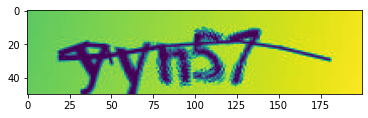

In [138]:
mask_img = (arr == np.asarray(label2arr('yyn57'))[None, :]).all(axis=2)
img = arr_data[mask_img]
plt.imshow(img[0][0])
plt.show()

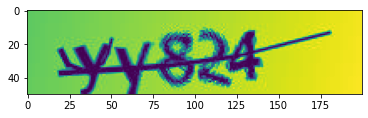

In [139]:
mask_img = (arr == np.asarray(label2arr('yy824'))[None, :]).all(axis=2)
img = arr_data[mask_img]
plt.imshow(img[0][0])
plt.show()

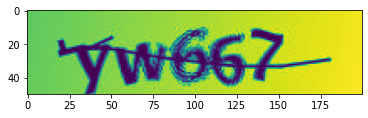

In [140]:
mask_img = (arr == np.asarray(label2arr('yw667'))[None, :]).all(axis=2)
img = arr_data[mask_img]
plt.imshow(img[0][0])
plt.show()

Или можно было бы просто у последних трех картинок убрать перечеркивающие линии около первой буквы и добавить в датасет. (Как только лимит гпу обновится, проверю)